#**스마트폰 센서 데이터 기반 모션 분류**
# 단계3 : 단계별 모델링


## 0.미션4

* 단계별로 나눠서 모델링을 수행하고자 합니다.  
* 단계 구분 예시
    * 단계1 : 정적(0), 동적(1) 행동 분류 모델 생성
    * 단계2 : 세부 동작에 대한 분류모델 생성
        * 단계1 모델에서 0으로 예측 -> 정적 행동 3가지 분류 모델링
        * 단계1 모델에서 1으로 예측 -> 동적 행동 3가지 분류 모델링
* (선택) 모델 통합
    * 두 단계 모델을 통합하고, 새로운 데이터에 대해서 최종 예측결과와 성능평가가 나오도록 함수로 만들기
* 성능 비교
    * 기본 모델링의 성능과 비교
    * 성능 가이드
        * Accuracy : 0.97 ~ 0.99
* (선택) 파이프라인 구성
    * test 데이터를 입력하여, 전처리 및 예측결과가 나오도록 함수 구성

## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project3 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

* 구글 드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/AIVLE/AI_미니프로젝트 1차_실습자료'

### (2) 라이브러리 불러오기

* 라이브러리 로딩
  - pandas, numpy,matplotlib,seaborn, joblib, 모델링에 필요한 라이브러리를 로딩합니다.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import *

from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.backend import clear_session
from keras.optimizers import Adam

In [ ]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

#### 1) 데이터로딩

In [ ]:
# 주어진 데이터 셋을 불러오세요.(3개)
train_data = pd.read_csv('/content/drive/MyDrive/AIVLE/AI_미니프로젝트 1차_실습자료/data01_train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/AIVLE/AI_미니프로젝트 1차_실습자료/data01_test.csv')
features = pd.read_csv('/content/drive/MyDrive/AIVLE/AI_미니프로젝트 1차_실습자료/features.csv')

In [ ]:
#불필요한 칼럼을 삭제하세요.
train_data = train_data.drop('subject',axis=1)
test_data = test_data.drop('subject',axis=1)

In [ ]:
train_data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS


#### 2) 기본 정보 조회

In [ ]:
#전체 데이터의 행,열 개수 확인
train_data.shape

(5881, 562)

In [ ]:
#전체 데이터의 상위 5개 행 확인
train_data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS


In [ ]:
#전체 데이터의 수치형 변수 분포 확인
train_data.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,...,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,0.274811,-0.017799,-0.109396,-0.603138,-0.509815,-0.604058,-0.628151,-0.525944,-0.605374,-0.465490,...,0.126955,-0.305883,-0.623548,0.008524,-0.001185,0.009340,-0.007099,-0.491501,0.059299,-0.054594
std,0.067614,0.039422,0.058373,0.448807,0.501815,0.417319,0.424345,0.485115,0.413043,0.544995,...,0.249176,0.322808,0.310371,0.339730,0.447197,0.608190,0.476738,0.509069,0.297340,0.278479
min,-0.503823,-0.684893,-1.000000,-1.000000,-0.999844,-0.999667,-1.000000,-0.999419,-1.000000,-1.000000,...,-0.965725,-0.979261,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.980143
25%,0.262919,-0.024877,-0.121051,-0.992774,-0.977680,-0.980127,-0.993602,-0.977865,-0.980112,-0.936067,...,-0.021610,-0.541969,-0.845985,-0.122361,-0.294369,-0.481718,-0.373345,-0.811397,-0.018203,-0.141555
50%,0.277154,-0.017221,-0.108781,-0.943933,-0.844575,-0.856352,-0.948501,-0.849266,-0.849896,-0.878729,...,0.133887,-0.342923,-0.712677,0.010278,0.005146,0.011448,-0.000847,-0.709441,0.182893,0.003951
75%,0.288526,-0.010920,-0.098163,-0.242130,-0.034499,-0.262690,-0.291138,-0.068857,-0.268539,-0.013690,...,0.288944,-0.127371,-0.501158,0.154985,0.285030,0.499857,0.356236,-0.511330,0.248435,0.111932
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,0.977344,0.478157,1.000000


In [ ]:
#전체 데이터의 모든 변수 확인

## 2.데이터 전처리

* 세부 요구사항
    - Label 추가 : 1단계 모델을 위한 레이블 추가
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

### (1) 1단계 모델링을 위한 레이블

In [ ]:
#Lable 추가(1단계 모델:정적(0), 동적(1) 행동 분류 모델 생성 )
train_data['is_dynamic'] = train_data['Activity'].apply(lambda x : 0 if x  in ['STANDING','SITTING','LAYING'] else 1)
test_data['is_dynamic'] = test_data['Activity'].apply(lambda x: 0 if x in ['STANDING','SITTING','LAYING'] else 1)


In [ ]:
train_data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity,is_dynamic
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING,0
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING,0
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING,0
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING,1
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS,1


### (2) x, y 분리

In [ ]:
#x,y 분리하기
y_train_is_dynamic = train_data['is_dynamic']
y_test_is_dynamic = test_data['is_dynamic']
y_train_6_class = train_data['Activity']
y_test_6_class = test_data['Activity']

x_train = train_data.drop(['is_dynamic','Activity'],axis=1)
x_test = test_data.drop(['is_dynamic','Activity'],axis=1)

### (3) 스케일링


* 세부 요구사항
    - 스케일링을 필요로 하는 알고리즘 사용을 위해서 코드 수행
    - min-max 방식 혹은 standard 방식 중 한가지 사용.

In [ ]:
#스케일링 방식을 선택해서 스케일링을 진행합니다.
ms = MinMaxScaler()
x_train = ms.fit_transform(x_train)
x_test = ms.transform(x_test)

### (4) 데이터 분할
* train, val 분할

In [ ]:
#데이터 분할 진행(train:val = 8:2 혹은 7:3 권장)
x_train_1,x_val_1,y_train_1,y_val_1 = train_test_split(x_train,y_train_is_dynamic,test_size=0.2) # is_dynamic
x_train_2,x_val_2,y_train_2,y_val2 = train_test_split(x_train,y_train_6_class,test_size=0.2) # 6classes

## **3.단계별 모델링**

### (1) 단계1

* 세부 요구사항
    * 적절한 단계로 구분한 후, 1단계를 분류하는 모델 생성
        * 예시 : 정적 행동(Laying, Sitting, Standing)과 동적 행동(동적 : Walking, Walking-Up, Walking-Down)을 구분하는 모델 생성.
    * 몇 가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.(기본 모델링 참고)

#### 1) 모델1

In [ ]:
# 모델 설계
# 모델 설계
model1 = Sequential([
    Dense(128,activation='relu', input_shape=(561,)),
    Dense(64,activation='relu'),
    Dense(32,activation='relu'),
    Dense(16,activation='relu'),
    Dense(1,activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# 컴파일 및 학습
# 컴파일 및 학습
model1.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history1 = model1.fit(x_train_1,y_train_1,epochs=20,batch_size=32,validation_data=(x_val_1,y_val_1),verbose=1)

Epoch 1/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9645 - loss: 0.1377 - val_accuracy: 0.9983 - val_loss: 0.0090
Epoch 2/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9997 - loss: 0.0018 - val_accuracy: 0.9992 - val_loss: 0.0070
Epoch 3/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9982 - loss: 0.0045 - val_accuracy: 0.9992 - val_loss: 0.0053
Epoch 4/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9996 - loss: 0.0014 - val_accuracy: 1.0000 - val_loss: 8.5206e-04
Epoch 5/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9998 - loss: 5.9532e-04 - val_accuracy: 0.9992 - val_loss: 0.0069
Epoch 6/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 7.7593e-05 - val_accuracy: 0.9992 - val_loss: 0.0052
Epoch 7/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 4.9230e-05 - val_accuracy: 0.9992 - val_loss: 0.0010
Epoch 8/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 1.8752e-0

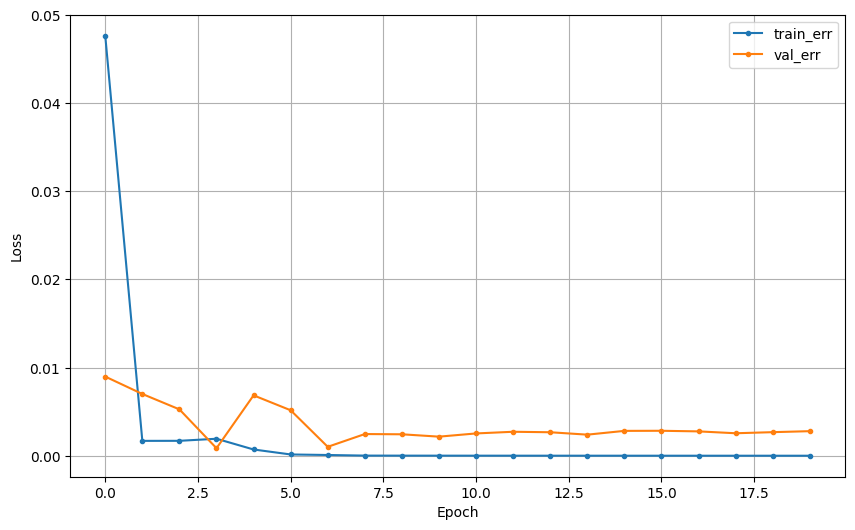

In [ ]:
# 학습곡선
# 학습곡선 함수
dl_history_plot(history1.history)



In [ ]:
# 예측 및 평가
loss, accuracy = model1.evaluate(x_test, y_test_is_dynamic)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.1935e-05
Test Loss: 0.0000
Test Accuracy: 1.0000


#### 2) 모델2

In [ ]:
# 모델 설계
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

model2 = Sequential([
    Dense(256, activation='relu', input_shape=(561,), kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
import tensorflow as tf
# 컴파일 및 학습
model2.compile(
    optimizer=Adam(learning_rate=0.0005),  # 학습률 감소
    loss='binary_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)

# Early Stopping 콜백 추가
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history2 = model2.fit(
    x_train_1, y_train_1,
    epochs=50,  # 최대 에포크 확장
    batch_size=64,  # 배치 크기 증가
    validation_data=(x_val_1, y_val_1),
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.9007 - loss: 0.7718 - precision: 0.8828 - recall: 0.8977 - val_accuracy: 0.9881 - val_loss: 0.6177 - val_precision: 0.9739 - val_recall: 1.0000
Epoch 2/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9967 - loss: 0.4549 - precision: 0.9945 - recall: 0.9981 - val_accuracy: 0.9975 - val_loss: 0.4332 - val_precision: 0.9943 - val_recall: 1.0000
Epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9996 - loss: 0.3909 - precision: 0.9997 - recall: 0.9995 - val_accuracy: 0.9992 - val_loss: 0.3609 - val_precision: 0.9981 - val_recall: 1.0000
Epoch 4/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9987 - loss: 0.3466 - precision: 0.9979 - recall: 0.9991 - val_accuracy: 1.0000 - val_loss: 0.3170 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 5/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9995 - loss: 0.3083 - precision: 0.9989 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.2794 - 

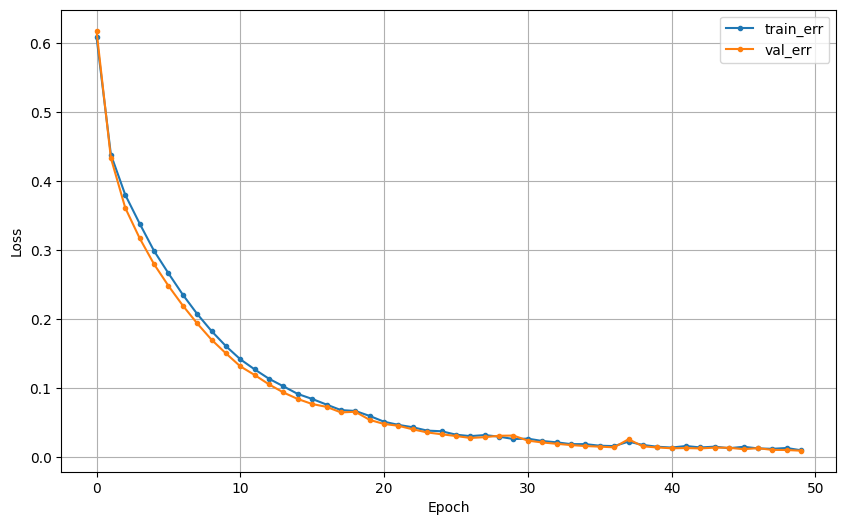

In [ ]:
# 학습곡선
dl_history_plot(history2.history)  # 손실과 평가지표 동시 관찰


In [ ]:
# 예측 및 평가
loss, accuracy, precision, recall = model2.evaluate(x_test, y_test_is_dynamic)
print(f"Test F1-Score: {(2 * precision * recall)/(precision + recall):.4f}")


46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0089 - precision: 1.0000 - recall: 1.0000
Test F1-Score: 1.0000


### (2) 단계2

#### 1) 단계2-1 : 정적 동작 세부 분류

* 세부 요구사항
    * 정적 행동(Laying, Sitting, Standing)인 데이터 추출
    * Laying, Sitting, Standing 를 분류하는 모델을 생성
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

In [ ]:
# (tip) 정적 행동(0)인 데이터 추출
train_data_static = train_data[train_data['is_dynamic'] == 0]
test_data_static = test_data[test_data['is_dynamic'] == 0].drop('is_dynamic',axis=1)
train_data_static = train_data_static.drop('is_dynamic',axis=1)
test_data_static

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.284379,-0.021981,-0.116683,-0.992490,-0.979640,-0.963321,-0.992563,-0.977304,-0.958142,-0.938850,...,-0.509523,-0.850065,-0.018043,0.092304,0.074220,-0.714534,-0.671943,-0.018351,-0.185733,SITTING
1,0.277440,-0.028086,-0.118412,-0.996620,-0.927676,-0.972294,-0.997346,-0.931405,-0.971788,-0.939837,...,-0.210792,-0.613367,-0.022456,-0.155414,0.247498,-0.112257,-0.826816,0.184489,-0.068699,STANDING
3,0.276053,-0.016487,-0.108381,-0.995379,-0.983978,-0.975854,-0.995877,-0.985280,-0.974907,-0.941425,...,-0.566291,-0.841455,0.289548,0.079801,-0.020033,0.291898,-0.639435,-0.111998,-0.123298,SITTING
4,0.271998,0.016904,-0.078856,-0.973468,-0.702462,-0.869450,-0.979810,-0.711601,-0.856807,-0.920760,...,0.447577,0.214219,0.010111,0.114179,-0.830776,-0.325098,-0.840817,0.116237,-0.096615,STANDING
6,0.447718,0.207096,-0.117430,-0.843029,-0.101380,-0.553765,-0.849087,-0.049920,-0.552505,-0.710284,...,-0.298895,-0.595825,-0.052553,0.173963,-0.214500,-0.259947,-0.794966,0.233738,-0.024725,STANDING
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1464,0.281468,-0.017691,-0.111765,-0.997293,-0.994022,-0.996573,-0.997599,-0.994098,-0.996554,-0.941409,...,-0.281085,-0.543776,0.064921,0.000456,0.064799,0.023543,-0.237356,-0.235869,-0.372354,SITTING
1465,0.273755,-0.013503,-0.102659,-0.971087,-0.937989,-0.941491,-0.979173,-0.936476,-0.940864,-0.896707,...,-0.338305,-0.765217,-0.042466,0.231895,0.062831,0.119820,-0.594376,0.005538,-0.258097,SITTING
1466,0.278725,-0.015262,-0.106398,-0.993625,-0.982845,-0.974745,-0.993963,-0.981100,-0.974596,-0.939303,...,-0.586580,-0.874066,-0.054788,0.712975,0.300318,-0.319188,-0.857336,0.120184,0.119276,SITTING
1467,0.275803,-0.019257,-0.109078,-0.998614,-0.991621,-0.987403,-0.998813,-0.991503,-0.986802,-0.945442,...,-0.451941,-0.721050,0.076333,-0.021599,-0.277268,0.754011,-0.764185,0.212111,0.138595,STANDING


In [ ]:
# (tip) 인코딩 진행, map 활용해서 숫자레이블로 매핑
# Laying : 0, Sitting : 1, Standing : 2로 매핑
train_data_static['Activity'] = train_data_static['Activity'].map({'LAYING':0,'SITTING':1,'STANDING':2})
test_data_static['Activity'] = test_data_static['Activity'].map({'LAYING':0,'SITTING':1,'STANDING':2})

static_data_y = train_data_static.pop('Activity')
test_data_y_static = test_data_static.pop('Activity')

In [ ]:
train_data_static

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.032207,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.246705,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,0.388765,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755
7,0.272026,-0.001329,-0.125491,-0.992068,-0.912985,-0.972451,-0.994752,-0.943141,-0.976428,-0.925446,...,-0.288935,-0.258503,-0.704995,-0.024442,0.076332,0.741277,0.729812,-0.817201,0.037746,0.136129
8,0.284338,0.021956,-0.006925,-0.980153,-0.838394,-0.782357,-0.983683,-0.816199,-0.743923,-0.914011,...,-0.194271,-0.052863,-0.400197,0.021212,-0.009465,-0.282762,0.563343,-0.782072,0.242834,-0.025285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5874,0.257476,-0.413865,0.017374,-0.919666,0.075259,-0.630716,-0.937986,0.176796,-0.613510,-0.866296,...,-0.269565,0.285085,-0.091605,-0.000793,0.267189,-0.186202,0.098099,0.792970,-0.034020,-0.928148
5875,0.277378,-0.013298,-0.104322,-0.996596,-0.987491,-0.973345,-0.996372,-0.987746,-0.973512,-0.942156,...,0.388907,-0.750064,-0.956239,0.122320,0.136275,-0.708377,-0.507788,-0.818263,0.222620,0.035430
5876,0.277194,-0.012389,-0.131974,-0.994046,-0.940578,-0.917337,-0.994261,-0.932830,-0.908088,-0.936219,...,0.052914,-0.305772,-0.690363,-0.034888,-0.261437,-0.391477,-0.877612,-0.912365,0.114009,0.080146
5878,0.267981,-0.018348,-0.107440,-0.991303,-0.989881,-0.990313,-0.992386,-0.988852,-0.991237,-0.936099,...,0.362439,-0.597610,-0.886851,0.060173,0.228739,0.684400,-0.216665,0.620363,-0.437247,-0.571840


In [ ]:
x_train_static,x_val_static,y_train_static,y_val_static = train_test_split(train_data_static,static_data_y,test_size=0.2)

In [ ]:
# 모델 설계
model2 = Sequential([
    Dense(128,activation='relu', input_shape=(561,)),
    Dense(64,activation='relu'),
    Dense(32,activation='relu'),
    Dense(16,activation='relu'),
    Dense(3,activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# 컴파일 및 학습
# 컴파일 및 학습
model2.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history2 = model2.fit(x_train_static,y_train_static,epochs=50,batch_size=32,validation_data=(x_val_static,y_val_static),verbose=1)

Epoch 1/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6469 - loss: 0.7722 - val_accuracy: 0.8918 - val_loss: 0.3188
Epoch 2/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8851 - loss: 0.2932 - val_accuracy: 0.9366 - val_loss: 0.1818
Epoch 3/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9157 - loss: 0.2107 - val_accuracy: 0.9289 - val_loss: 0.1853
Epoch 4/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9292 - loss: 0.1675 - val_accuracy: 0.9536 - val_loss: 0.1131
Epoch 5/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9503 - loss: 0.1270 - val_accuracy: 0.9598 - val_loss: 0.1170
Epoch 6/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9496 - loss: 0.1293 - val_accuracy: 0.9552 - val_loss: 0.1210
Epoch 7/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9481 - loss: 0.1320 - val_accuracy: 0.9645 - val_loss: 0.0938
Epoch 8/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9613 - loss: 0.1108 - val_accuracy: 0.9567 - val_loss:

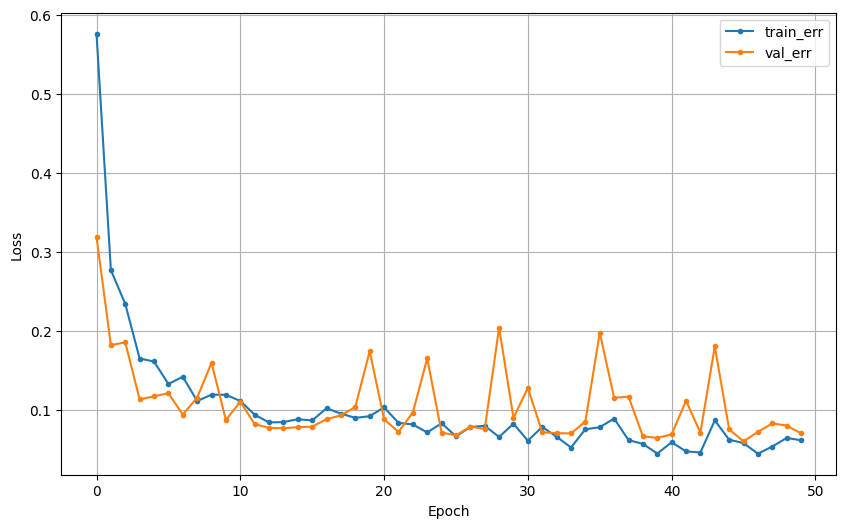

In [ ]:
# 학습곡선
dl_history_plot(history2.history)


In [ ]:
# 예측 및 평가
loss, accuracy = model2.evaluate(test_data_static,test_data_y_static)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9702 - loss: 0.0876
Test Loss: 0.1027
Test Accuracy: 0.9592


#### 2) 단계2-2 : 동적 동작 세부 분류

* 세부 요구사항
    * 동적 행동(Walking, Walking Upstairs, Walking Downstairs)인 데이터 추출
    * Walking, Walking Upstairs, Walking Downstairs 를 분류하는 모델을 생성
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

In [ ]:
# (tip) 동적 행동(1)인 데이터 추출
train_data_dynamic = train_data[train_data['is_dynamic'] == 1]
train_data_dynamic = train_data_dynamic.drop('is_dynamic',axis=1)
test_data_dynamic = test_data[test_data['is_dynamic'] == 1]
test_data_dynamic = test_data_dynamic.drop('is_dynamic',axis=1)
test_data_dynamic.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
2,0.305833,-0.041023,-0.087303,0.006880,0.182800,-0.237984,0.005642,0.028616,-0.236474,0.016311,...,0.579587,0.394388,-0.362616,0.171069,0.576349,-0.688314,-0.743234,0.272186,0.053101,WALKING
5,0.336801,0.010528,-0.057819,-0.435988,-0.126317,0.037931,-0.446406,-0.244650,-0.034606,-0.288437,...,0.115015,-0.351891,-0.174328,0.558749,0.664988,0.544573,-0.775712,0.187548,0.149686,WALKING
9,0.087902,-0.118993,-0.052787,-0.217817,-0.148752,0.079020,-0.294967,-0.165066,0.137718,0.070103,...,-0.535753,-0.842876,0.313940,0.577018,-0.968008,0.525585,-0.872144,0.186079,0.007999,WALKING_UPSTAIRS
16,0.267601,-0.032814,-0.113073,-0.290751,0.028228,-0.011504,-0.341515,0.043469,0.048429,-0.226421,...,-0.475586,-0.795217,-0.082706,0.206094,-0.917195,-0.365769,-0.616598,0.353675,0.087181,WALKING_UPSTAIRS
17,0.187920,-0.022493,-0.114320,-0.285203,-0.001438,0.163397,-0.339592,-0.134192,0.172202,0.093298,...,-0.381085,-0.806618,0.765867,-0.099255,0.815948,0.007978,-0.796053,0.199388,0.119815,WALKING


In [ ]:
# (tip) map 활용해서 숫자레이블로 매핑핑
train_data_dynamic['Activity'] = train_data_dynamic['Activity'].map({'WALKING':0,'WALKING_UPSTAIRS':1,'WALKING_DOWNSTAIRS':2})
test_data_dynamic['Activity'] = test_data_dynamic['Activity'].map({'WALKING':0,'WALKING_UPSTAIRS':1,'WALKING_DOWNSTAIRS':2})

dynamic_data_y = train_data_dynamic.pop('Activity')
test_data_y_dynamic = test_data_dynamic.pop('Activity')
x_train_dynamic,x_val_dynamic,y_train_dynamic,y_val_dynamic = train_test_split(train_data_dynamic,dynamic_data_y,test_size=0.2)

In [ ]:
# 모델 설계
# 모델 설계
model3 = Sequential([
    Dense(128,activation='relu', input_shape=(561,)),
    Dense(64,activation='relu'),
    Dense(32,activation='relu'),
    Dense(16,activation='relu'),
    Dense(3,activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# 컴파일 및 학습
model3.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history3 = model3.fit(x_train_dynamic,y_train_dynamic,epochs=50,batch_size=32,validation_data=(x_val_dynamic,y_val_dynamic),verbose=1)

Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7377 - loss: 0.6518 - val_accuracy: 0.9377 - val_loss: 0.1591
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9583 - loss: 0.1233 - val_accuracy: 0.9623 - val_loss: 0.1121
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9702 - loss: 0.0655 - val_accuracy: 0.9528 - val_loss: 0.1134
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9897 - loss: 0.0257 - val_accuracy: 0.9868 - val_loss: 0.0368
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9903 - loss: 0.0240 - val_accuracy: 0.9868 - val_loss: 0.0372
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9944 - loss: 0.0188 - val_accuracy: 0.9906 - val_loss: 0.0233
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9970 - loss: 0.0100 - val_accuracy: 0.9925 - val_loss: 0.0205
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9992 - loss: 0.0041 - val_accuracy: 0.9887 - val_loss:

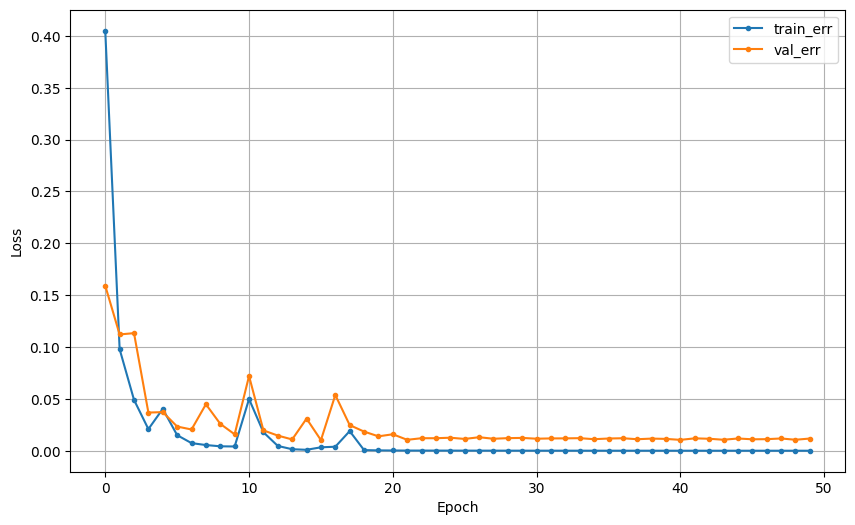

In [ ]:
# 학습곡선
dl_history_plot(history3.history)


In [ ]:
# 예측 및 평가
loss, accuracy = model3.evaluate(test_data_dynamic,test_data_y_dynamic)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9959 - loss: 0.0135
Test Loss: 0.0116
Test Accuracy: 0.9953


### (3) (옵션) 분류 모델 파이프라인 구성


* 세부 요구사항
    * 두 단계 모델을 통합하고, 새로운 데이터(test)에 대해서 최종 예측결과와 성능평가가 나오도록 함수로 만들기
    * 데이터 파이프라인 구축 : test데이터가 로딩되어 전처리 과정을 거치고, 예측 및 성능 평가 수행

* 예시
![](https://github.com/DA4BAM/image/blob/main/pipeline%20function.png?raw=true)

#### 1) 함수 만들기

In [ ]:
#(tip) 함수 만들기
# 1. 전처리
# 1-1. 스케일링
# 1-2. 입력값 만들기
#-------------------
# 2. 예측하기
# 2-1. 단계1을 모델로 0,1 구분
# 2-2. 단계 1의 결과로 데이터 나누기
# 2-3. 단계2 모델로 예측
# 2-4. 예측 결과 원래 값으로 변환
# 2-5. 하나로 합쳐보기
#-------------------
# 3. 최종 성능평가 하기

In [82]:
class_names_s = ['LAYING', 'SITTING', 'STANDING']
class_names_a = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS']

def pipeline(test_data, model1, model_s, model_a, scaler1, scaler_s, scaler_a, class_names_s, class_names_a):

    # 1. 입력과 실제 정답 분리
    x = test_data.drop(columns=['Activity'])
    y_true = test_data['Activity'].values

    # 1-1. 단계1 전처리 (스케일링)
    x_scaled1 = scaler1.transform(x)

    # 2-1. 단계1 예측 (정적/동적 구분)
    pred_is_dynamic = model1.predict(x_scaled1)
    pred_is_dynamic_label = (pred_is_dynamic > 0.5).astype(int).reshape(-1)

    # 2-2. 정적/동적 분리
    x_static = x[pred_is_dynamic_label == 0]
    x_dynamic = x[pred_is_dynamic_label == 1]

    idx_static = np.where(pred_is_dynamic_label == 0)[0]
    idx_dynamic = np.where(pred_is_dynamic_label == 1)[0]

    # 최종 결과 담을 배열
    pred_final = np.empty(len(test_data), dtype=object)

    # 2-3. 정적 행동 예측
    if len(x_static) > 0:
        x_s_scaled = scaler_s.transform(x_static)
        pred_s = model_s.predict(x_s_scaled)
        pred_s_label = np.argmax(pred_s, axis=1)
        pred_s_final = [class_names_s[i] for i in pred_s_label]
        pred_final[idx_static] = pred_s_final

    # 2-3. 동적 행동 예측
    if len(x_dynamic) > 0:
        x_a_scaled = scaler_a.transform(x_dynamic)
        pred_a = model_a.predict(x_a_scaled)
        pred_a_label = np.argmax(pred_a, axis=1)
        pred_a_final = [class_names_a[i] for i in pred_a_label]
        pred_final[idx_dynamic] = pred_a_final

    # 3. 성능 평가
    acc = accuracy_score(y_true, pred_final)
    cm = confusion_matrix(y_true, pred_final, labels=np.unique(y_true))
    report = classification_report(y_true, pred_final)

    return acc, cm, report

print(pipeline(data_test, model1, model_s, model_a,scaler1, scaler_s, scaler_a,class_names_s, class_names_a))

NameError: name 'data_test' is not defined

#### 2) test 셋으로 예측하고 평가하기

In [ ]:
# test 셋의 구조 한번 확인해보고 성능평가 해보기